# Keras Confusion Matrix
The goal of this notebook is to demonstrate how to create a confusion matrix using the Keras API. To start off with, we are going to figure out how to make a confusion matrix using a two-class problem using the Tor/NonTor dataset.

In [1]:
# DataFrame handling
import pandas as pd

# keras Models
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import CategoricalAccuracy, TruePositives, FalsePositives, TrueNegatives, FalseNegatives, Recall, Precision

# Split data with stratified cv
from sklearn.model_selection import train_test_split

# Encoding of classifications
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical, normalize

print('Imports complete.')

Using TensorFlow backend.


Imports complete.


## Import Data
We're using the `getXy` function here to import the data file we hand it and split it up into `X` (for the sample data) and `y` for the target classifications. Using this technique, we are able to easily access both the data and class for a given sample without every accidently handing a model both pieces of information, unless on purpose, else we'd produce a model that is a great cheater.  

The `getXy` function is extremely convenient when we have to train on multiple datasets. Instead of going through all of the same code over and over again, we simply call this function to retrieve it.

In [2]:
def getXy(filename='', verbose=False, dep_var=None):
    """
        This function takes a filename, loads the data into a dataframe, then separates the classification data
        
        args:
            filename => str, path to csv file to be loaded
            
        returns:
            list(X,y) => data, classifications
    """
    df = pd.read_csv(filename)
    
    if verbose:
        print('Before encoding and splitting:')
        print(df.head())
        print('\nData Composition')
        print(df[dep_var].value_counts())
    
    # Actual data
    X = df.loc[:, df.columns != dep_var]
    
    # Set number of classes we see
    num_classes = df[dep_var].nunique()
    
    # Classifications
    encoder = LabelEncoder()
    y = encoder.fit_transform(df[dep_var])
    
    if verbose:
        print('Classification encoding:')
        for i in range(len(encoder.classes_)):
            print('\t{} => {}'.format(i, encoder.classes_[i]))
        
        print('After encoding and splitting:')
        print('X = ')
        print(X.head())
        print('\ny = ')
        print(y[:5])
    
    # X holds the data while y holds the classifications
    return X, y

Now that we've defined this function, we need to set up some constants, load in the data, and fix it up. Normalizing the data is just a typical process to look at how the data changes with respect to the averages for column. We call the `to_categorical` function to [one-hot encode](https://en.wikipedia.org/wiki/One-hot) the `y` (target classification) data.

In [3]:
# Define the random states for reproducibility
random_state = 1

# Import the data file
path = '../../tor_dataset/'
scenario = 'Scenario-A/'
file = 'TimeBasedFeatures-15s-TOR-NonTOR.csv'

# Define the dependent variable
dep_var = 'class'

X, y = getXy(path + scenario + file, dep_var=dep_var, verbose=True)


# Normalize the data in X and categorize y
X = normalize(X)
y = to_categorical(y)

Before encoding and splitting:
   duration  total_fiat  total_biat  min_fiat  min_biat       max_fiat  \
0   9368711          16           4   1564818   1549373  190205.285714   
1   7340238          18           4   1567554   1527893  165686.977273   
2   4644225          29          15   1270547   1079974  165865.178571   
3   4978735          19           8   2492050   2457286  239543.250000   
4  11838189          19          10   3094089   3093543  243766.500000   

        max_biat      mean_fiat      mean_biat  flowPktsPerSecond  ...  \
0  203290.456522  389822.391917  370323.719754          10.353612  ...   
1  186914.846154  317267.548742  304370.651301          11.580006  ...   
2  195302.130435  329473.126261  300492.588227          11.412022  ...   
3  276596.388889  612435.304238  628339.573544           8.034169  ...   
4  295954.725000  599721.781709  625632.703972           7.602514  ...   

     std_flowiat  min_active   mean_active  max_active    std_active  \
0  2676

We see a ton of output from this `getXy` function because we've set the `verbose` flag. The only reason this is necessary is so we can look at the composition of the data, i.e. we want to know how many of each class there is in the dataset. As we can see above, we have 18,758 NonTor labels and 3,314 Tor labels.   

Let's make sure the data is what we'd expect now that we've messed with it. We want `y` to be one-hot encoded and the data composition should not change.

In [4]:
print(y[:5])
summed = [0, 0]
for sample in y:
    summed[0] += sample[0]
    summed[1] += sample[1]
print(summed)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[18758.0, 3314.0]


We can see above that the `y` data is correctly encoded! Under this output, we also see the sum of each column. From this, we can conclude that the NonTor label is the first index (idx = 0) of the encoded system and Tor is in the second (idx = 1). What can we do with this information? Let's keep track of this in an array, below.

In [5]:
names = ['NONTOR', 'TOR']

Just to be extra sure, let's make sure that `X` and `y` are the same length.

In [6]:
print('Length of X: {}'.format(len(X)))
print('Length of y: {}'.format(len(y)))

Length of X: 22072
Length of y: 22072


Great! Everything is in line for us to split the data up into training and testing sets.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [8]:
print('Length of X_train: {}'.format(len(X_train)))
print('Length of y_train: {}'.format(len(y_train)))
print('Length of X_test: {}'.format(len(X_test)))
print('Length of y_test: {}'.format(len(y_test)))

Length of X_train: 17657
Length of y_train: 17657
Length of X_test: 4415
Length of y_test: 4415


## Training the Model
Now that we've split up the data, we see that a majority of the data is in the training sets. This is what is expected. We will now create the metric objects and the deep learning model.

In [9]:
metrics = [
    CategoricalAccuracy(),
    TruePositives(),
    FalsePositives(),
    TrueNegatives(),
    FalseNegatives(),
    Recall(),
    Precision()
]
model = Sequential([
            Dense(64, input_shape=(23,)),
            Dense(32, activation='relu'),
            Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

We will train the model we've created on the training data for 10 rounds/epochs.

In [10]:
model.fit(X_train, y_train, epochs=10, verbose=2)

Epoch 1/10
552/552 - 2s - loss: 0.0511 - categorical_accuracy: 0.9840 - true_positives: 17375.0000 - false_positives: 282.0000 - true_negatives: 17375.0000 - false_negatives: 282.0000 - recall: 0.9840 - precision: 0.9840
Epoch 2/10
552/552 - 2s - loss: 0.0061 - categorical_accuracy: 0.9990 - true_positives: 17639.0000 - false_positives: 18.0000 - true_negatives: 17639.0000 - false_negatives: 18.0000 - recall: 0.9990 - precision: 0.9990
Epoch 3/10
552/552 - 2s - loss: 0.0053 - categorical_accuracy: 0.9991 - true_positives: 17641.0000 - false_positives: 16.0000 - true_negatives: 17641.0000 - false_negatives: 16.0000 - recall: 0.9991 - precision: 0.9991
Epoch 4/10
552/552 - 2s - loss: 0.0051 - categorical_accuracy: 0.9991 - true_positives: 17641.0000 - false_positives: 16.0000 - true_negatives: 17641.0000 - false_negatives: 16.0000 - recall: 0.9991 - precision: 0.9991
Epoch 5/10
552/552 - 2s - loss: 0.0049 - categorical_accuracy: 0.9991 - true_positives: 17641.0000 - false_positives: 16.0

From the output above, we see that the model is performing with around 99% accuracy on the data. However, accuracy isn't always the best way to determine the performance of a model. Of the metrics we are collecting, we see that Recall and Precision are also both high (~99%).   

Further, it is a very likely possibility that the model is overfit to the training data. In order to test the model, we will use the `test` datasets. This is seen below.

In [11]:
results = model.evaluate(X_test, y_test)

print('Metrics:')
print('\tLoss\tAcc\tTP\tFP\tTN\tFN\tRecall\tPrecision')
for result in results:
    print('\t{:.2f}'.format(result), end='')

138/138 [==============================] - 0s 4ms/step - loss: 0.0038 - categorical_accuracy: 0.9991 - true_positives: 4411.0000 - false_positives: 4.0000 - true_negatives: 4411.0000 - false_negatives: 4.0000 - recall: 0.9991 - precision: 0.9991
Metrics:
	Loss	Acc	TP	FP	TN	FN	Recall	Precision
	0.00	1.00	4411.00	4.00	4411.00	4.00	1.00	1.00

We can see extremely high performance from this model. However, what if I want to visualize the performance of the model? Well, just as it happens, that is the entire point of this notebook! In the next section, we will discuss creating a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).  
## Confusion Matrix
To start off with, let's make sure we can specifically look at the predictions on the test data. We can see the first five predictions below.

In [12]:
print('Predictions:')
predictions = model.predict(X_test)
print(predictions[:5])

print('Actual:')
print(y_test[:5])

Predictions:
[[9.9999917e-01 8.1983643e-07]
 [1.5324163e-07 9.9999988e-01]
 [2.6143357e-07 9.9999976e-01]
 [9.9999988e-01 1.5195921e-07]
 [9.9999976e-01 2.0177721e-07]]
Actual:
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


As it turns out, while our `y_test` variable has only ones and zeros, our predicted values are somewhere in-between zero and one. Since we are using the `softmax` activation function in the output layer of the neural network, the sum of the values here add up to one. Thus, we interpret these values as the probability distribution over the given classifications. In the first sample we see here, the model is saying there is a 99.99% chance the sample belongs to zero-th classification (which is NonTor from our names array). In contrast, the model believes there is an extremely high probability that the second and third samples belong to the Tor classification.   

To create a confusion matrix, we need to interpret these predictions and map them into a matrix with the predicted classification on one axis and the actual classification the other. We create an example of matrix below.

In [13]:
matrix = [ [ 0 for j in range(len(predictions[0]))]  for i in range(len(predictions[0]))]
print(matrix[:5])

[[0, 0], [0, 0]]


We will interpret the chosen classification for a model as the highest-percentage output node for a given sample. We demonstrate the method below.

In [14]:
import numpy as np

# Acquire the probability distribution for the first sample
first_pred = predictions[0]

# Return the index of the highest value in this probability distribution. 
#  This index is used to define the voted class in accordance to our names
#  array.
guess = np.argmax(first_pred)

print('Guess: {}'.format(guess))
print('Actual: {}'.format(np.argmax(y_test[0])))

Guess: 0
Actual: 0


To create the confusion matrix, we will go through all of the sample classes and predictions, marking on the matrix where the vote of the model is. 

In [15]:
# Used to print the matrix in an easy fashion, however this is not the level of fancy that we strive for
def print_matrix(matrix):
    print('\tPredicted')
    for name in names:
        print('\t{}'.format(name), end='')
    print('\n', end='')
    for i in range(len(matrix)):
        print('{}'.format(names[i]), end='')
        for col in matrix[i]:
            print('\t{}'.format(col), end='')
        print('\n', end='')

In [16]:
matrix = [ [ 0 for j in range(len(predictions[0]))]  for i in range(len(predictions[0]))]
print('Initial matrix:')
print_matrix(matrix)
for i in range(len(predictions)):
    pred = predictions[i]
    test = y_test[i]
    
    guess = np.argmax(pred)
    actual = np.argmax(test)
    
    matrix[actual][guess] += 1
    
print('\nFilled matrix:')
print_matrix(matrix)

Initial matrix:
	Predicted
	NONTOR	TOR
NONTOR	0	0
TOR	0	0

Filled matrix:
	Predicted
	NONTOR	TOR
NONTOR	3783	0
TOR	4	628


Now, we have first confusion matrix! However, it is not nearly fancy enough for our purposes here. Let's use some graphing techniques!

Indices: Index(['NONTOR', 'TOR'], dtype='object')
        NONTOR  TOR
NONTOR    3783    0
TOR          4  628


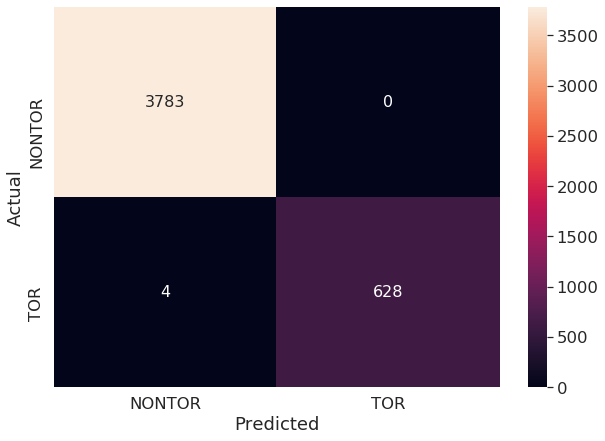

In [17]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(matrix, range(len(matrix)), range(len(matrix)))
int_cols = df_cm.columns
df_cm.columns = names
df_cm.index = names
print('Indices: {}'.format(df_cm.index))

print(df_cm.head())
plt.figure(figsize=(10,7))
sn.set(font_scale=1.5) # for label size
ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

plt.show()

We have now successfully produced a confusion matrix. Let's throw this idea into a function and make it scalable. Once this is complete, we will test (and validate) the results with a larger categorical dataset!

## Streamline and Scale

In [18]:
def show_conf_matrix(model, X_test, y_test, names):
    # Techniques from https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
    # and https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix#51163585
    
    predictions = model.predict(X_test)
    matrix = [ [ 0 for j in range(len(predictions[0])) ]  for i in range(len(predictions[0])) ]
    for i in range(len(predictions)):
        pred = predictions[i]
        test = y_test[i]

        guess = np.argmax(pred)
        actual = np.argmax(test)

        matrix[actual][guess] += 1
        
    df_cm = pd.DataFrame(matrix, range(len(matrix)), range(len(matrix)))
    int_cols = df_cm.columns
    df_cm.columns = names
    df_cm.index = names

    plt.figure(figsize=(10,7))
    sn.set(font_scale=1.5) # for label size
    ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

    plt.show()

Let's test our fancy new function on the data we've already seen to make sure something hasn't gone terribly wrong somewhere.

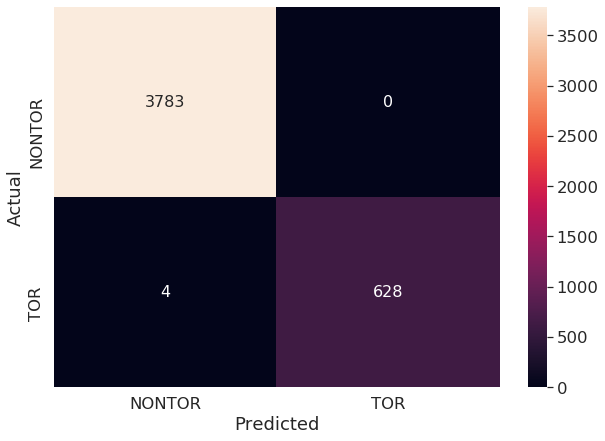

In [19]:
names = ['NONTOR', 'TOR']
show_conf_matrix(model, X_test, y_test, names)

This all checks out!

## Trust but Verify
Now, don't get excited yet. This is just the same result that we produced earlier. Let's import the other categorical dataset and observe the effects. There will be minimal markdown below because we have already gone through these steps with the Tor/NonTor dataset.

In [20]:
# Define the random state for reproducibility and set the dependent variable we expect
random_state = 1
dep_var = 'class'

# Define the path to the dataset
path = '../../tor_dataset/'

# Set the scenario type (Directs to correct directory)
scenario = 'Scenario-B/'

# Define the file we want to talk about
file = 'TimeBasedFeatures-15s-Layer2.csv'

# Import the data and split it up based on the dependent variable
X, y = getXy(path + scenario + file, dep_var=dep_var, verbose=True)

Before encoding and splitting:
   duration  total_fiat  total_biat  min_fiat  min_biat  max_fiat  max_biat  \
0  10345300    10345257    10345174        60        52   5871778   5870638   
1  14966353    14966200    14966053         7         0    635321    635242   
2    272867      233627      272820     20303     19353    213324    253467   
3  14999391    14998887    14999391         0         0    149034    146556   
4   7190597     7189947     7190597       116       492   6555090   6594711   

       mean_fiat      mean_biat  flowPktsPerSecond  ...   std_flowiat  \
0  517262.850000  470235.181818           4.253139  ...  1.022685e+06   
1   10502.596491    5615.779737         273.413302  ...  2.134758e+04   
2  116813.500000  136410.000000          21.988734  ...  9.018174e+04   
3    9062.771601    4758.690038         320.613017  ...  9.995782e+03   
4  898743.375000  898824.625000           2.503269  ...  1.582350e+06   

   min_active  mean_active  max_active    std_active  m

In [21]:
# Clean up the dataset so we can work with Keras easier

# Normalize the x data
X = normalize(X)

# Use One-Hot Encoding for the classification data, in this case we know there are going to be 8 categories, 
#  there will 8 columns of ones and zeros in the encoded version
y = to_categorical(y, num_classes=8)

In [22]:
print(y[:3])

[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


In [23]:
# Split up the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

print('Size of train set:')
print('\tX: {}'.format(len(X_train)))
print('\ty: {}'.format(len(y_train)))
print('Size of test set:')
print('\tX: {}'.format(len(X_test)))
print('\ty: {}'.format(len(y_test)))

Size of train set:
	X: 2688
	y: 2688
Size of test set:
	X: 672
	y: 672


In [24]:
# Create the metrics for the deep learning model
metrics = [
    CategoricalAccuracy(),
    TruePositives(),
    FalsePositives(),
    TrueNegatives(),
    FalseNegatives(),
    Recall(),
    Precision()
]

# Create the model
model = Sequential([
            Dense(64, input_shape=(23,)),
            Dense(32, activation='relu'),
            Dense(8, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [25]:
model.fit(X_train, y_train, epochs=10, verbose=0)

In [26]:
results = model.evaluate(X_test, y_test)

print('Metrics:')
print('\tLoss\tAcc\tTP\tFP\tTN\tFN\tRecall\tPrecision')
for result in results:
    print('\t{:.2f}'.format(result), end='')

21/21 [==============================] - 0s 3ms/step - loss: 1.2100 - categorical_accuracy: 0.5253 - true_positives_1: 269.0000 - false_positives_1: 142.0000 - true_negatives_1: 4562.0000 - false_negatives_1: 403.0000 - recall_1: 0.4003 - precision_1: 0.6545
Metrics:
	Loss	Acc	TP	FP	TN	FN	Recall	Precision
	1.21	0.53	269.00	142.00	4562.00	403.00	0.40	0.65

I'm not sure why the metrics we see above look like they're from the training set. I cannot explain this, however we will keep moving on. If you figure this out, please let me know!

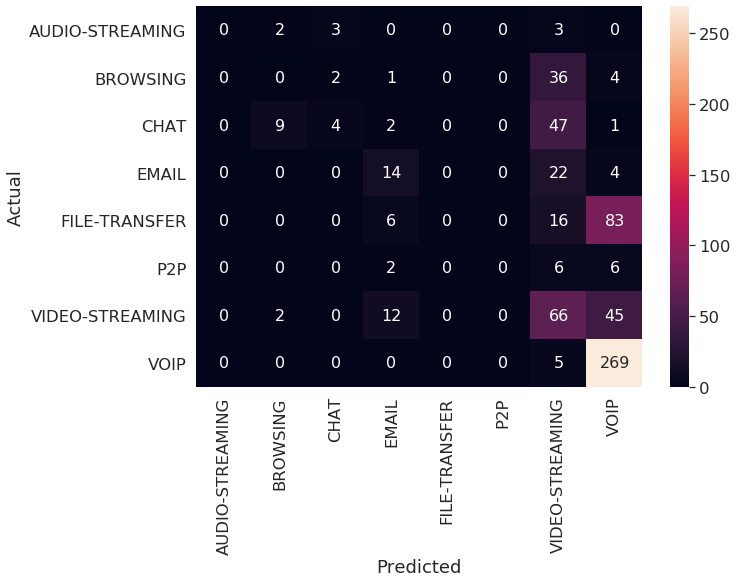

In [27]:
# Gathered from the getXy function
#0 => AUDIO-STREAMING
#1 => BROWSING
#2 => CHAT
#3 => EMAIL
#4 => FILE-TRANSFER
#5 => P2P
#6 => VIDEO-STREAMING
#7 => VOIP
names = ['AUDIO-STREAMING', 'BROWSING', 'CHAT', 'EMAIL', 'FILE-TRANSFER', 'P2P', 'VIDEO-STREAMING', 'VOIP']
show_conf_matrix(model, X_test, y_test, names)

Beautiful! We have now demonstrated our capabilities in generating a fancy confusion matrix.